##[MAIN QUEST 3] 폐렴아 기다려라!
-프로젝트 제출: 1점
-루브릭: 4점
  - 의료영상을 처리하는 CNN 기반 베이스 모델 구현
  - 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교
  - 모델 구조 변경을 통해 베이스 모델과의 성능 비교
  - ResNet-18 모델을 구현하고 학습 성공
  
  개요, 목차, 주석 및 의견, summary, 회고, reference 등이 포함되지 않을 경우 감점 1점 

# (1) 의료영상을 처리하는 CNN 기반 베이스 모델 구현

#1. Set-up

In [1]:
##1-1. 라이브러리 import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
##1-2. 앞으로 필요한 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 8
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


#2.데이터 가져오기

In [3]:
##2-1. 데이터 가져와서 개수 체크

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
##2-2. train과 val에 있는 데이터를 모은 후, train:val을 80:20으로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 80:20으로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
##2-3. train 데이터 안의 정상이미지 수와 폐렴이미지 수 구분: 정상보다 폐렴 이미지 수가 3배 더 많음

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
##2-4. tf.data 인스턴스 만들기: tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줌

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 라벨 데이터 만들어주는 함수: 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분가능
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

Training images count: 4185
Validating images count: 1047


In [7]:
##2-5. 이미지의 사이즈 통일 및 감소: decode_img 함수와 process_path 함수 생성

# 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# get_label을 이용해서 라벨 값을 가져오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# train 데이터셋과 validation 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지가 잘 리사이즈 및 라벨링이 되었는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [8]:
##2-6. 테스트 데이터셋 생성 및 데이터셋 개수 확인

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [9]:
##2-7. tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 하기

def prepare_for_training(ds, shuffle_buffer_size=1000): #tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) #shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() #repeat()를 사용해서 여러 번 데이터셋을 사용할 수 있게 해주기
    ds = ds.batch(BATCH_SIZE) #batch()를 사용해서 BATCH_SIZE에서 정한 만큼의 배치로 주어지도록 하기
    ds = ds.prefetch(buffer_size=AUTOTUNE) #prefetch()를 사용해서 학습 데이터를 나눠서 읽어오게 하기
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#3. 데이터 시각화

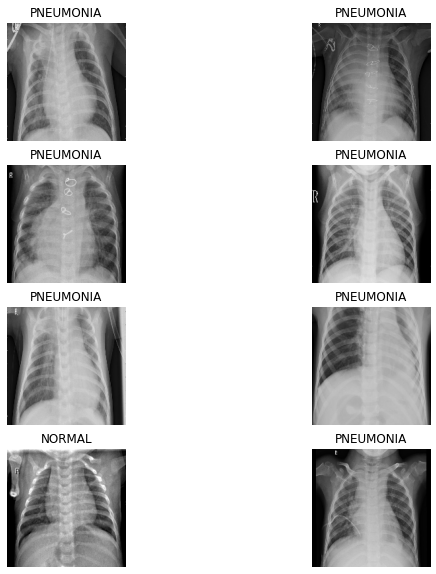

In [10]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여주게 설정
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE): #train에 있는 batch 중 첫 번째 배치를 추출
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds)) #추출된 배치를 image와 label 데이터 셋으로 나누기
show_batch(image_batch.numpy(), label_batch.numpy()) #show_batch() 함수를 이용해서 결과 사진보기

#4.CNN 모델링

In [11]:
#4-1.Convolution block 생성
def conv_block(filters):
    block = tf.keras.Sequential([ #Convolution을 두 번 진행
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'), 
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), #Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D() #Max Pooling
    ])
    
    return block

In [12]:
#4-2. Dense block 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [13]:
#4-3. 모델 생성
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#5. 데이터 imbalance 처리

In [14]:
# Weight balancing: training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


#6. 모델 훈련

In [15]:
#6-1. 이미지 훈련을 위해 gpu 선택 및 build_model()을 model에 선언

with tf.device('/GPU:0'):
    model = build_model()

    #성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',  #optimizer로 'adam'을 사용
        loss='binary_crossentropy',  #이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
        metrics=METRICS
    )

In [16]:
#6-2. 모델을 fit 하기

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
523/523 [==============================] - 67s 103ms/step - loss: 0.4932 - accuracy: 0.7562 - precision: 0.9263 - recall: 0.7307 - val_loss: 1.7657 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 53s 102ms/step - loss: 0.3006 - accuracy: 0.8702 - precision: 0.9652 - recall: 0.8564 - val_loss: 0.4139 - val_accuracy: 0.7625 - val_precision: 0.7552 - val_recall: 1.0000
Epoch 3/15
523/523 [==============================] - 54s 103ms/step - loss: 0.2930 - accuracy: 0.8726 - precision: 0.9651 - recall: 0.8600 - val_loss: 0.1070 - val_accuracy: 0.9615 - val_precision: 0.9725 - val_recall: 0.9751
Epoch 4/15
523/523 [==============================] - 54s 102ms/step - loss: 0.2631 - accuracy: 0.8908 - precision: 0.9723 - recall: 0.8783 - val_loss: 0.1512 - val_accuracy: 0.9481 - val_precision: 0.9863 - val_recall: 0.9423
Epoch 5/15
523/523 [==============================] - 54s 104ms/step - loss: 0.2633 - accura

#7. 결과 확인

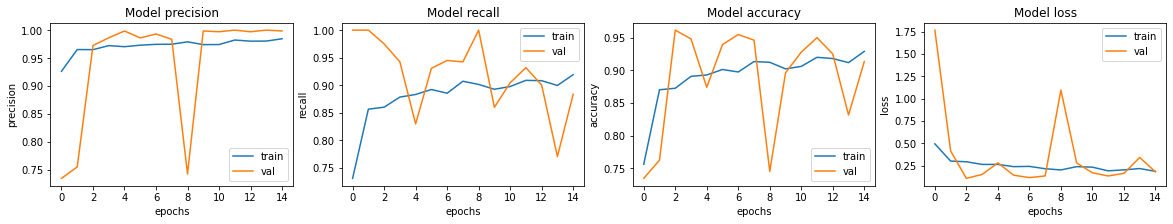

In [23]:
#7-1. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
#7-2. 테스트 데이터로 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 5s 59ms/step - loss: 0.4991 - accuracy: 0.8606 - precision: 0.8483 - recall: 0.9462
Loss: 0.4991457164287567,
Accuracy: 0.8605769276618958,
Precision: 0.8482758402824402,
Recall: 0.9461538195610046


#8. Summary

CNN 기반 베이스 모델을 이용해서 폐렴 진단에 있어서 80% 정도까지만 맞출 수 있게 되었기 때문에 성능을 개선해야 함. 
Data augmentation을 기법을 사용하면 모델이 더 일반화되어, 데이터셋에 대한 과적합을 줄이고 더 다양한 예시를 학습하게 되며,
loss는 약간 증가하더라도 정확도가 개선될 수 있음.

# (2) 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교

#1. 데이터 augmentation 적용

In [25]:
import tensorflow as tf

#1-1. Augmentation 레이어 정의

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),   # 수평으로 뒤집기
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),        # 회전
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),           # 확대/축소
    tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.2)),  # 밝기 변화
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)           # 값 범위 [0, 1]로 스케일링
])

In [26]:
#1-2. 기존 모델에 Augmentation 추가

def build_augmented_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        data_augmentation,  # 여기서 데이터 augmentation을 추가
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#2. 모델 정의 및 훈련

In [27]:
#2-1. 모델 정의

with tf.device('/GPU:0'):
    augmented_model = build_augmented_model()

    augmented_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
#2-2. 모델 훈련

with tf.device('/GPU:0'):
    augmented_history = augmented_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
523/523 [==============================] - 63s 103ms/step - loss: 0.8507 - accuracy: 0.5002 - precision: 0.7608 - recall: 0.5519 - val_loss: 0.5954 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 53s 102ms/step - loss: 0.7666 - accuracy: 0.5012 - precision: 0.7410 - recall: 0.5071 - val_loss: 0.9740 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
523/523 [==============================] - 53s 102ms/step - loss: 0.7266 - accuracy: 0.5041 - precision: 0.7470 - recall: 0.5051 - val_loss: 0.6170 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/15
523/523 [==============================] - 53s 102ms/step - loss: 0.7115 - accuracy: 0.4880 - precision: 0.7413 - recall: 0.4794 - val_loss: 1.4378 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
523/523 [==============================] - 54s 104ms/step - loss:

#3. 성능 비교

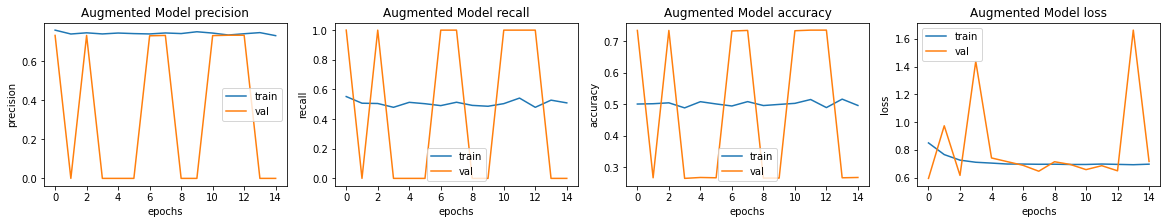

In [29]:
#3-1. 결과 그래프

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(augmented_history.history[met])
    ax[i].plot(augmented_history.history['val_' + met])
    ax[i].set_title('Augmented Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
#3-2. 성능 평가

loss, accuracy, precision, recall = augmented_model.evaluate(test_ds)
print(f'Augmented Model\nLoss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

78/78 [==============================] - 5s 64ms/step - loss: 0.7066 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Augmented Model
Loss: 0.7065995335578918, Accuracy: 0.375, Precision: 0.0, Recall: 0.0


#4. Summary

1. 베이스 모델
Loss: 50%
Accuracy: 86%
Precision: 75%
Recall: 84.8%

2. Augmented 모델
Loss: 71%
Accuracy: 37.5%
Precision: 0%
Recall: 0%
    
베이스 모델은 정확도와 정밀도가 더 높아서, 전반적인 성능에서 우수한 모델로 보임.
Augmented 모델은 예측과 달리 성능이 크게 저하됨. 이는 모델이 전혀 의미 있는 예측을 하지 못한 상태임. 특히 Precision과 Recall이 모두 0으로 나왔다는 것은, 모델이 양성 클래스나 음성 클래스에 대해서도 제대로 된 예측을 하지 못하고 있다는 것을 의미함.


# 3. 모델 구조 변경을 통해 베이스 모델과의 성능 비교 

In [31]:
# 데이터셋과 배치 크기 준비 확인
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

# class_weight 확인
class_weight = {0: 1.0, 1: 2.0}


In [32]:
#1. Residual Block 정의 

def residual_block(x, filters):
    skip = x
    
    # 첫 번째 Conv2D와 BatchNormalization
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # 두 번째 Conv2D와 BatchNormalization
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation=None, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Skip connection의 차원이 맞지 않으면 차원 맞추기
    if skip.shape[-1] != x.shape[-1]:
        skip = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(skip)  # 1x1 Convolution으로 차원 맞추기
    
    # Skip connection 추가
    x = tf.keras.layers.Add()([x, skip])
    x = tf.keras.layers.ReLU()(x)
    
    return x


In [33]:
# 2. 새로운 모델 설계

def build_residual_model(image_size=(180, 180)):
    inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))
    
    # Conv Block
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)

    # Residual Block 적용
    x = residual_block(x, 32)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    
    # Flatten & Dense Block
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # 출력층
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [34]:
# 3. 모델 생성 및 컴파일

with tf.device('/GPU:0'):
    residual_model = build_residual_model()
    residual_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

In [35]:
# 4. 모델 훈련

history_residual = residual_model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/15


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 180, 180, 3), found shape=(None, None, 180, 180, 3)


#5. Summary

다시 시도를 계속 해봤지만 accuracy면에서도 모델이 계속 변동성이 크고, 예측대로 augmentation을 해도 성능이 오르지 않고, 구조 변경 모델의 경우에도 계속 오류가 뜸. 뭔가 잘못된 것 같은데... 결국 바로잡지 못해서 중단.

회고: 다음 번에 제대로 다시 복습해서 오류가 계속 나오는 이유를 찾는 시간을 가져봐야겠다. 세팅에서부터 계속 문제가 생기고, gpu가 부족하다는 얘기가 계속 나와서 처음부터 다시 돌아가고 했더니 이번에는 augmentation 모델에서 accuracy가 급속도로 낮아졌다. 그리고 끝내 구조변경 모델은 에러를 해결하지 못한 것 같다.. 이미지 사이즈랑 배치 사이즈 다시 맞췄는데도 오류가 새로운 게 계속 생긴다. 다시 고민해봐야겠다.. ㅠㅠ 지금까지 했던 것 중 가장 어려웠던 과제.. 아직 케라스를 전혀 이해를 못한 기분이다. 